No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


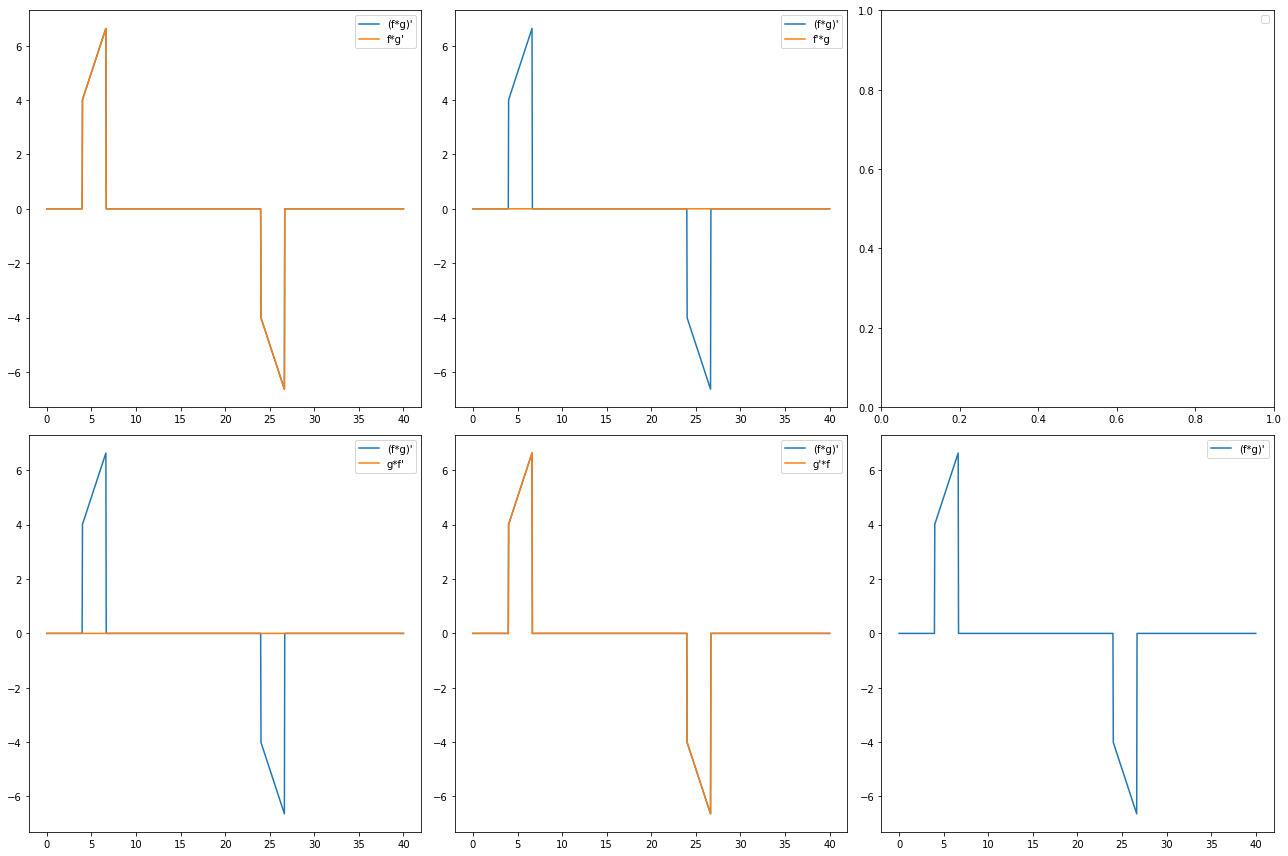

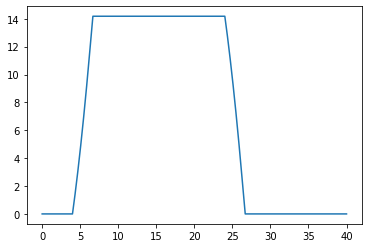

In [5]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

r = 20
alpha = 5
beta = 3

# Analytical functions
def f(x):
    return np.heaviside(x , 1)

def g(x):
    return x * (np.heaviside(x - r /alpha, 1) - np.heaviside(x -  r / beta, 1))

# xの範囲と微小変化を定義します
x = np.linspace(0, 20, 1000)
dx = x[1] - x[0]

# Using numpy's gradient function to calculate the derivatives
f_prime_x = np.gradient(f(x), dx)
g_prime_x = np.gradient(g(x), dx)

# 関数f, gの畳み込みを計算します
conv = signal.convolve(f(x), g(x), mode='full') * dx

# 畳み込みの微分を計算します
d_conv = np.gradient(conv, dx)

# Compute convolution of f and derivative of g, and vice versa
f_der_g = signal.convolve(f(x), g_prime_x, mode='full') * dx
g_der_f = signal.convolve(f_prime_x, g(x), mode='full') * dx

# Compute convolution of g and derivative of f, and vice versa
g_der_f_new = signal.convolve(g(x), f_prime_x, mode='full') * dx
f_der_g_new = signal.convolve(g_prime_x, f(x), mode='full') * dx

# 結果をプロットします
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 範囲を調整
x_full = np.linspace(0, 40, len(d_conv))

# Plot (f*g)' in all subplots except axs[0, 2]
for i, ax in enumerate(axs.flat):
    if i != 2:  # Skip the third subplot (axs[0, 2])
        ax.plot(x_full, d_conv, label="(f*g)'")

# Plot other results
axs[0, 0].plot(x_full, f_der_g, label="f*g'")
axs[0, 1].plot(x_full, g_der_f, label="f'*g")
axs[1, 0].plot(x_full, g_der_f_new, label="g*f'")
axs[1, 1].plot(x_full, f_der_g_new, label="g'*f")

# Add legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()

plt.plot(x_full, conv, label = "simple conv")
plt.show()


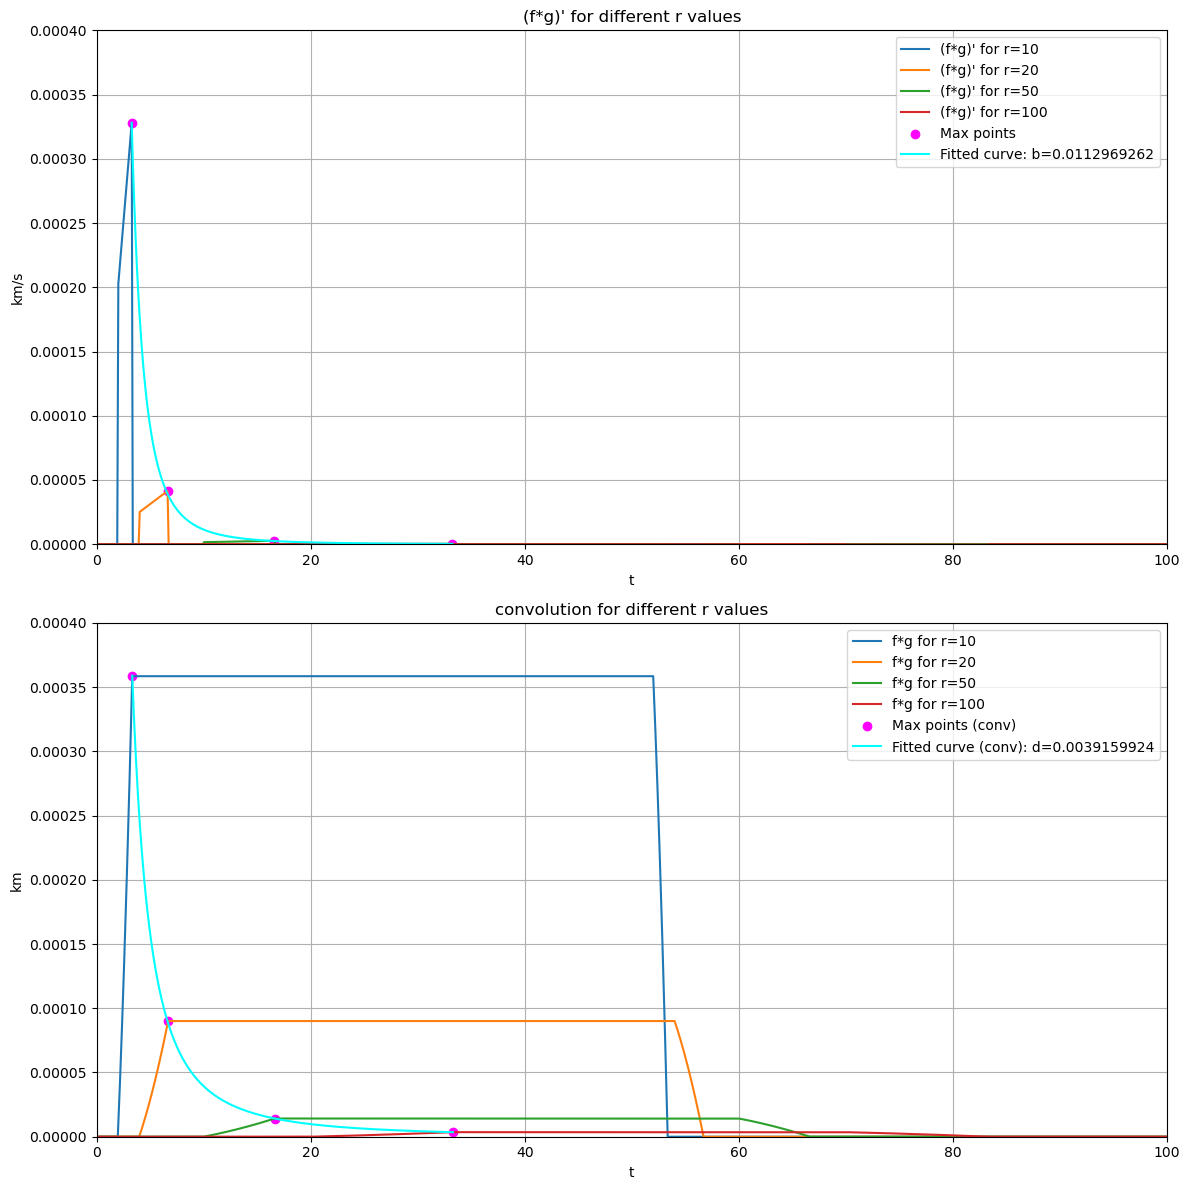

In [43]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 50, 100]

# 畳み込む関数
def f(t):
    return np.heaviside(t, 1)

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# tの値
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2

params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 0.0004])


plt.tight_layout()
plt.show()


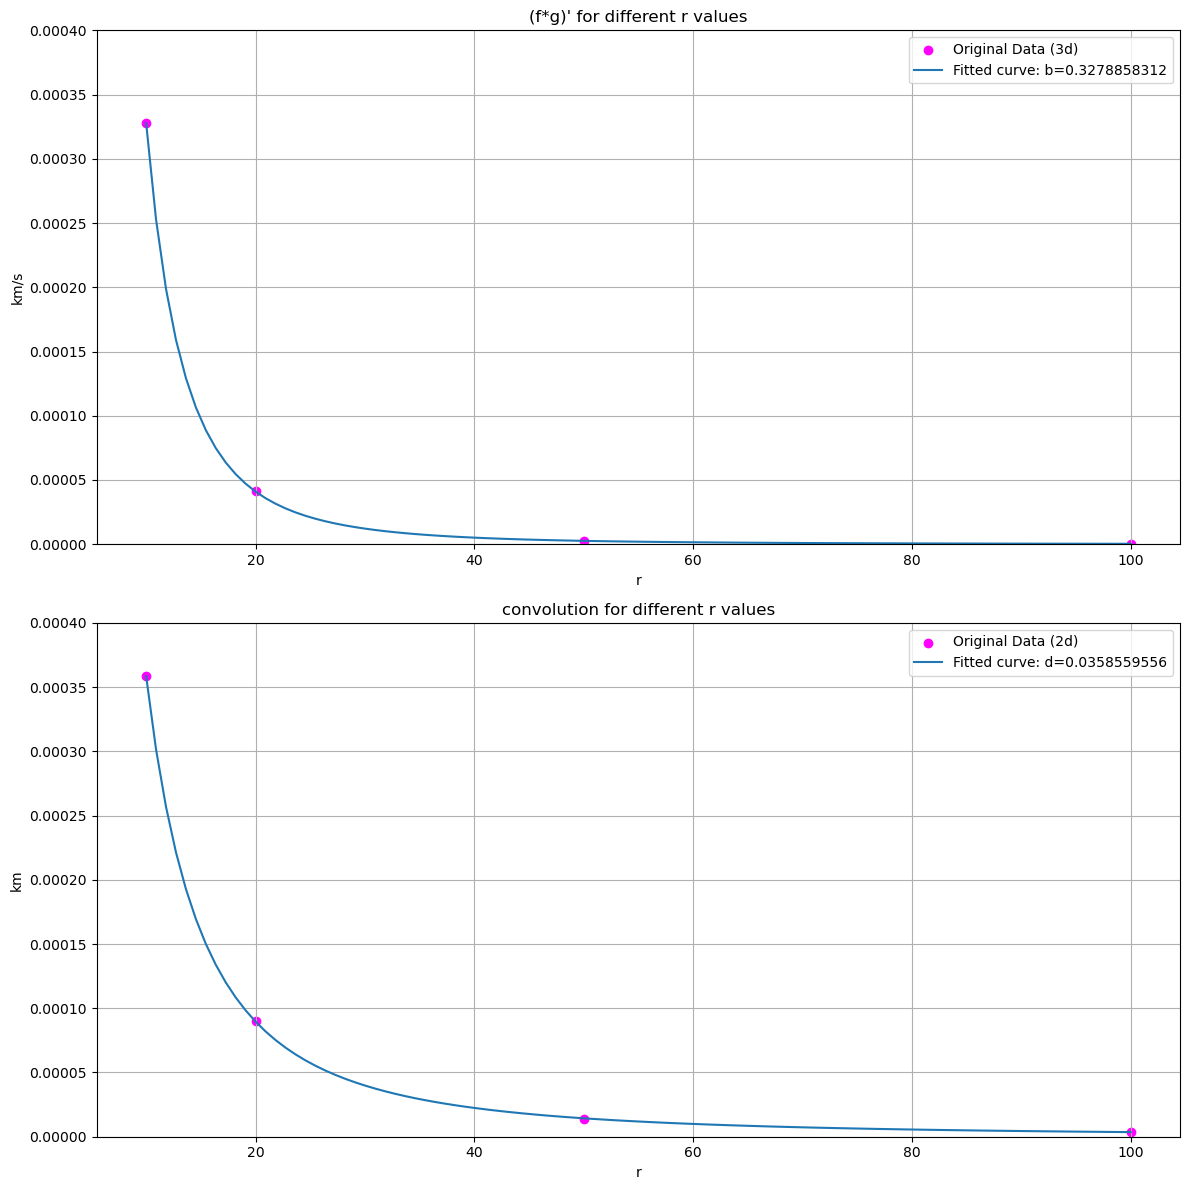

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
r_values_dense = np.linspace(min(r_values), max(r_values), 100)   # 密なxの範囲を生成

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

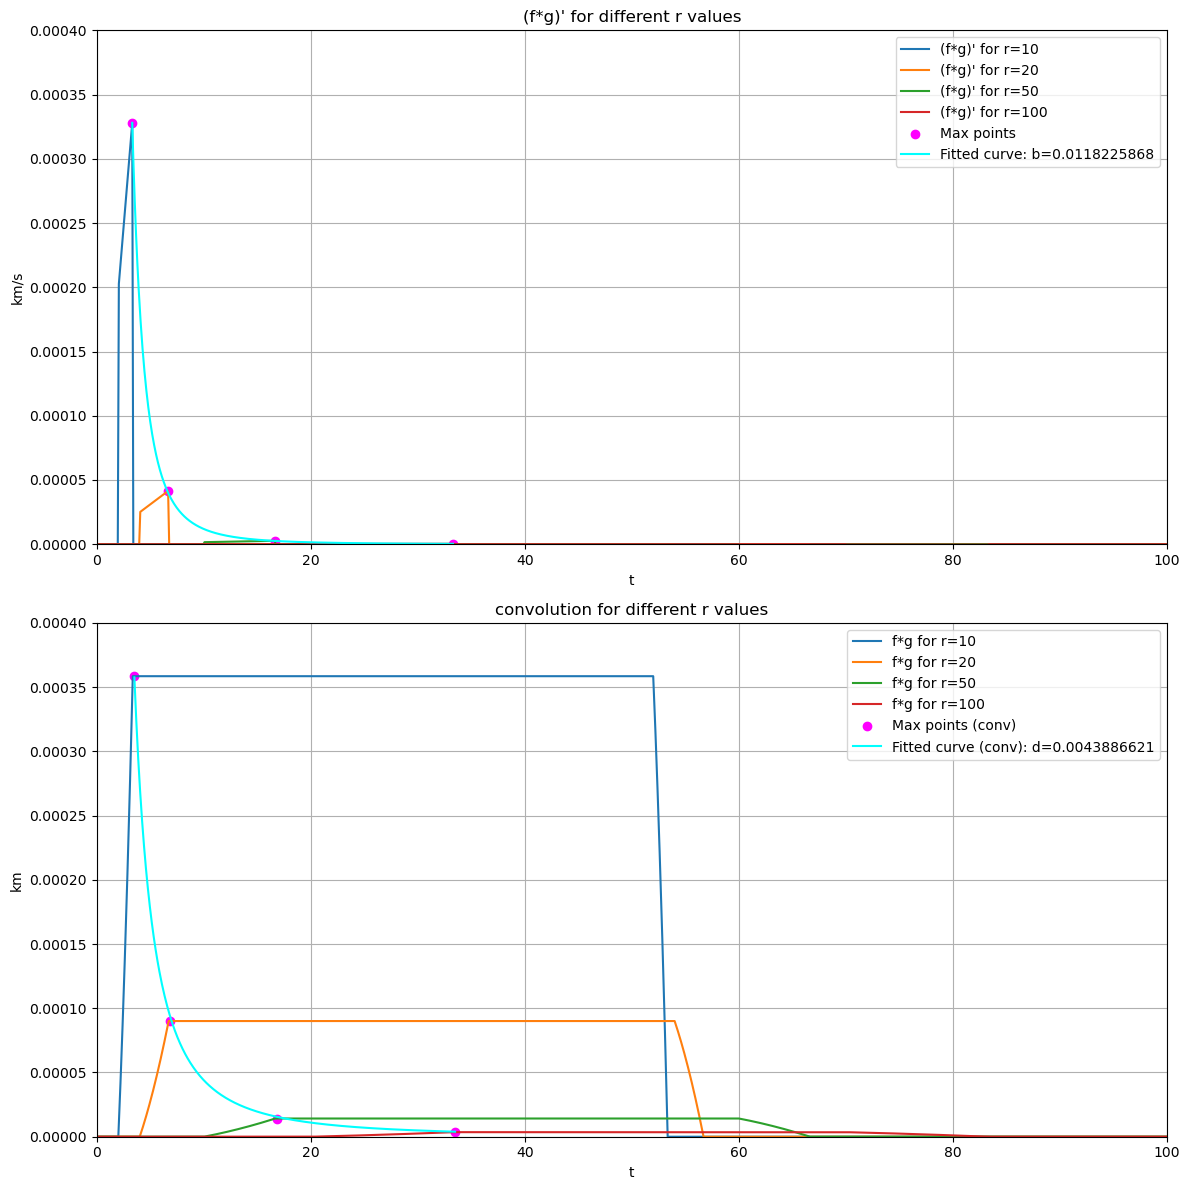

In [45]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 50, 100]

# 畳み込む関数
def f(t):
    return np.tanh(t/0.01)

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# tの値
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2

params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 0.0004])

plt.tight_layout()
plt.show()


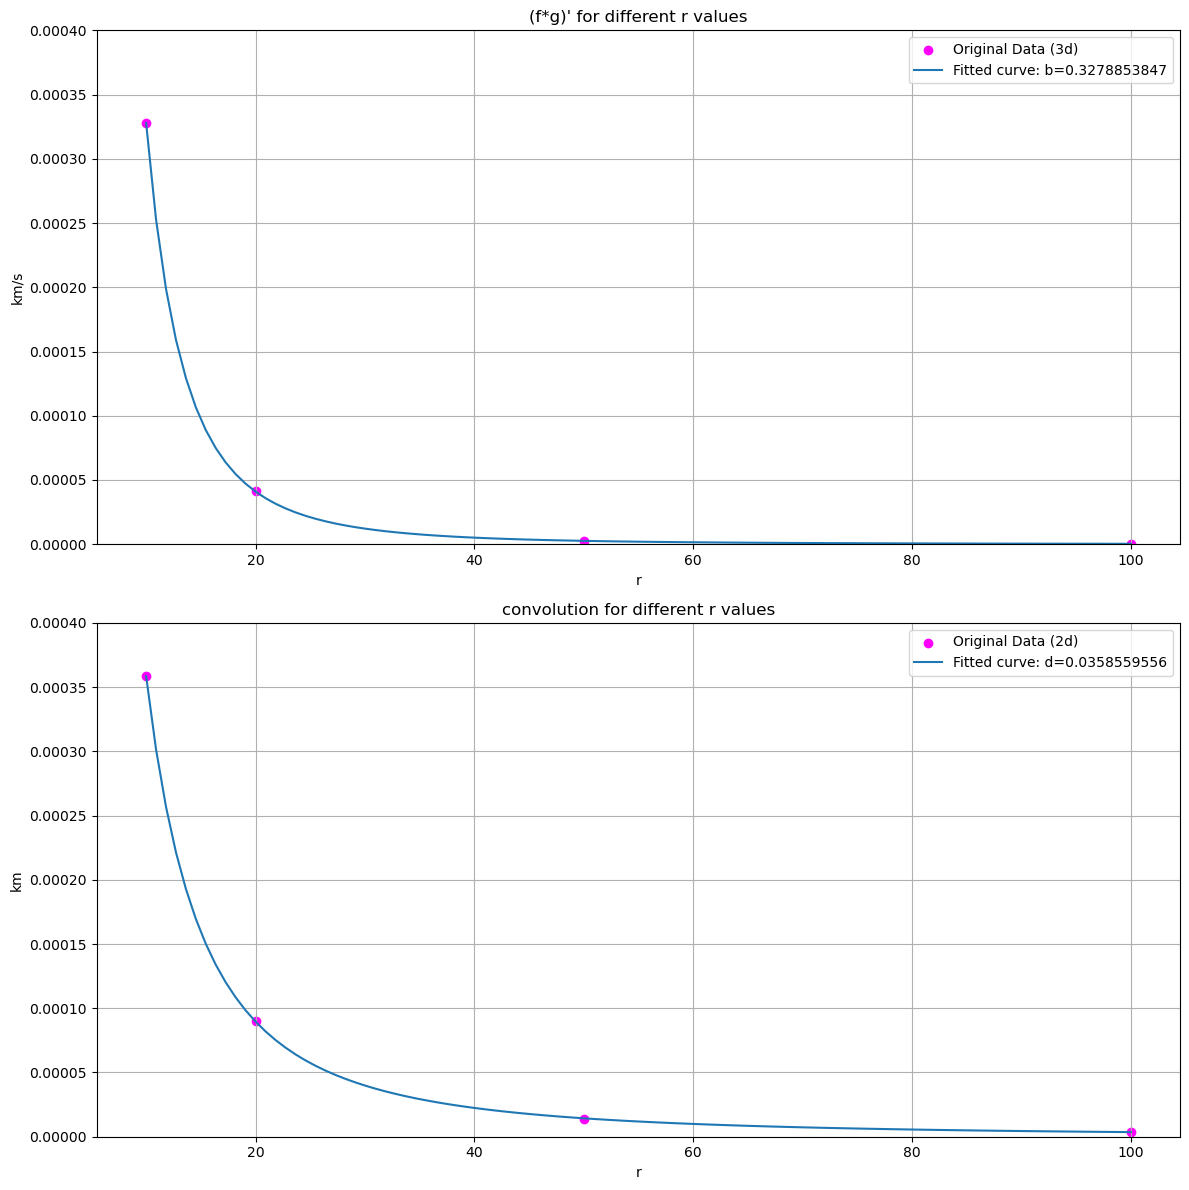

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
r_values_dense = np.linspace(min(r_values), max(r_values), 100)   # 密なxの範囲を生成

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

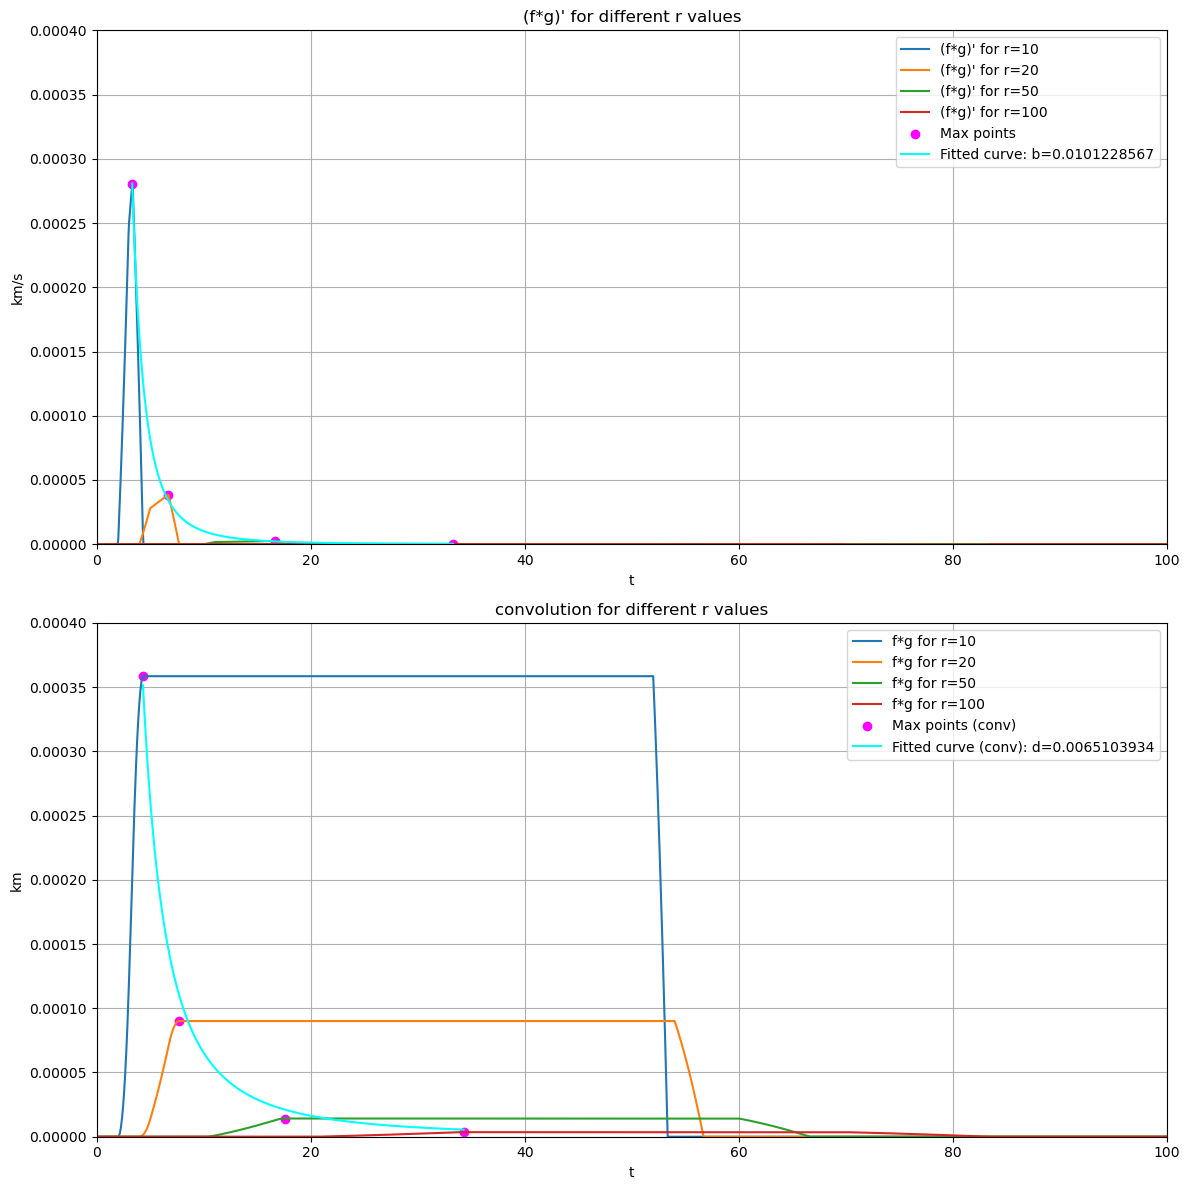

In [47]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# パラメータ
alpha = 5
beta = 3
r_values = [10, 20, 50, 100]

# 畳み込む関数
def f(t):
    result = np.zeros_like(t)
    mask1 = (0 <= t) & (t < 1)
    mask2 = t >= 1
    result[mask1] = t[mask1]
    result[mask2] = 1
    return result

def g(t, r):
    return t * (np.heaviside(t - r / alpha, 1) - np.heaviside(t - r / beta, 1)) / r ** 4

# tの値
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# 畳み込み積分用の範囲
t_full = np.linspace(0, 100, len(t) * 2 - 1)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 速度の最大値を取得する
max_values = []
max_t_values = []

# 変位の最大値を取得する
max_values_conv = []
max_t_values_conv = []

for r in r_values:
    # f,gを微分する
    f_prime_t = np.gradient(f(t), dt)
    g_prime_t = np.gradient(g(t, r), dt)

    # f*g 畳み込み
    conv = signal.convolve(f(t), g(t, r), mode='full') * dt

    # 畳み込みの微分(f*g)'
    d_conv = np.gradient(conv, dt)

    # 速度の最大値とそうなるtを得る
    max_value = np.max(d_conv)
    max_t_value = t_full[np.argmax(d_conv)]
    max_values.append(max_value)
    max_t_values.append(max_t_value)
    
    # 変位の最大値とそうなるtを得る
    max_value_conv = np.max(conv)
    max_t_value_conv = t_full[np.argmax(conv)]
    max_values_conv.append(max_value_conv)
    max_t_values_conv.append(max_t_value_conv)

    # Plot 
    axs[0].plot(t_full, d_conv, label=f"(f*g)' for r={r}")

    # Plot 
    axs[1].plot(t_full, conv, label=f"f*g for r={r}")

# Function to fit: y = b/t**3
def func_3d(t, b):
    return b / t**3

# Use curve_fit to find the best b
params, _ = curve_fit(func_3d, max_t_values, max_values)
b_opt = params[0]
t_fit = np.linspace(min(max_t_values), max(max_t_values), 500)
y_fit = func_3d(t_fit, b_opt)

# Function to fit: y = d/t**2
def func_2d(t, d):
    return d / t**2


params_conv, _ = curve_fit(func_2d, max_t_values_conv, max_values_conv)
d_opt = params_conv[0]
t_fit_conv = np.linspace(min(max_t_values_conv), max(max_t_values_conv), 500)
y_fit_conv = func_2d(t_fit_conv, d_opt)

# Plot max_t_values and max_values
axs[0].scatter(max_t_values, max_values, color='magenta', label='Max points')
axs[0].plot(t_fit, y_fit, color='cyan', label=f'Fitted curve: b={b_opt:.10f}')
axs[0].legend()

# Plot the new fitted function in axs[1]
axs[1].scatter(max_t_values_conv, max_values_conv, color='magenta', label='Max points (conv)')
axs[1].plot(t_fit_conv, y_fit_conv, color='cyan', label=f'Fitted curve (conv): d={d_opt:.10f}')
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('t')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('t')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 0.0004])

plt.tight_layout()
plt.show()


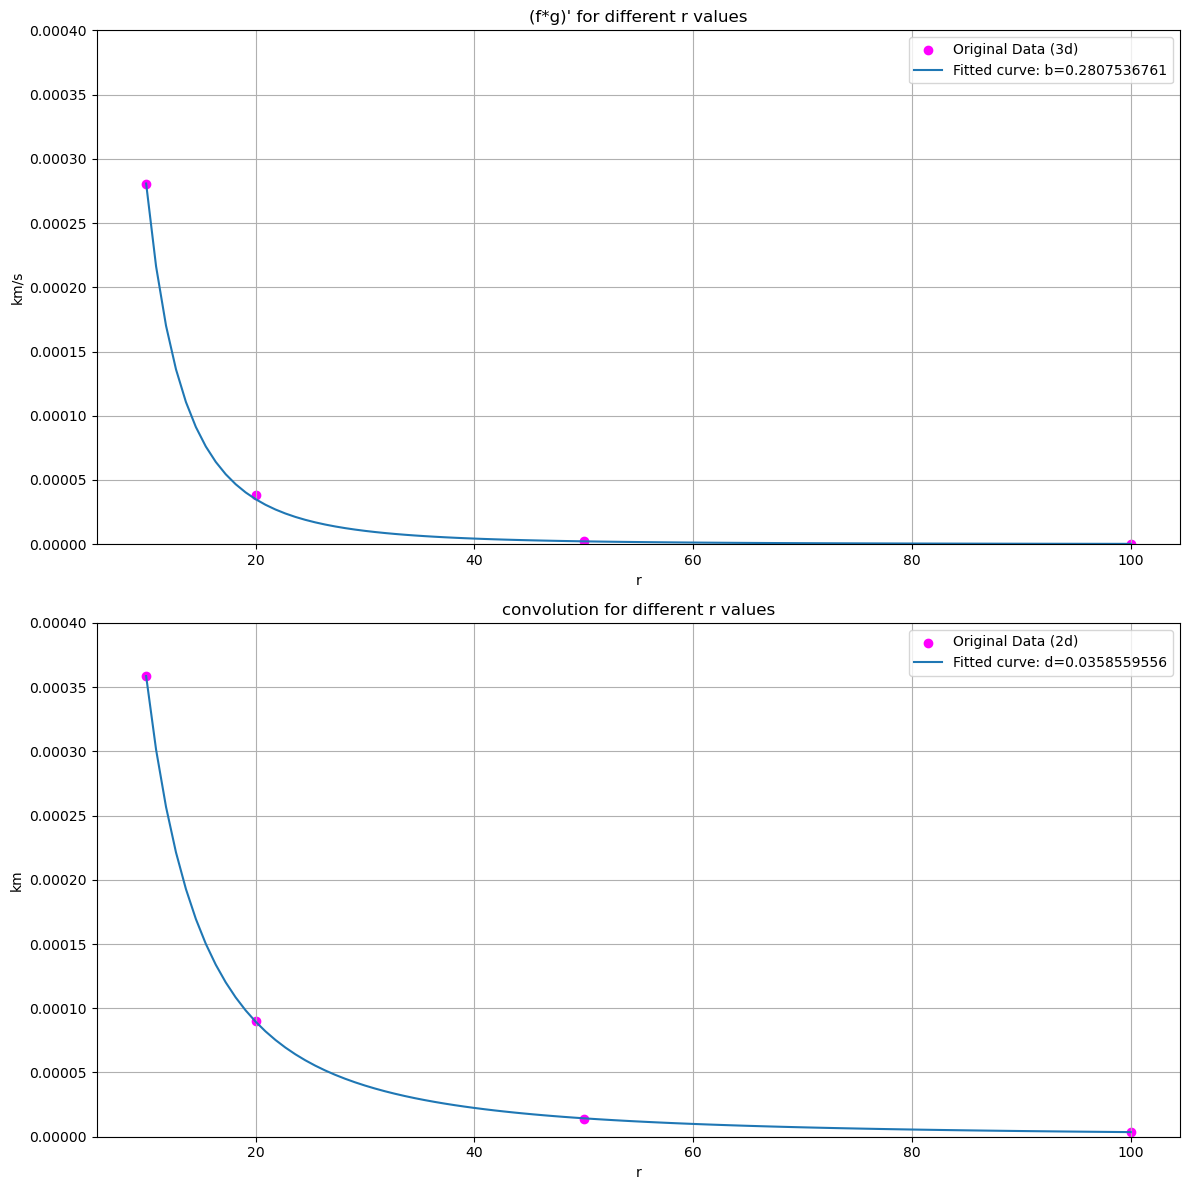

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# フィッティング用の関数を定義
def func_3d(t, b):
    return b / t**3

def func_2d(t, d):
    return d / t**2

# curve_fitを使用して、データを関数にフィットさせる
params, _ = curve_fit(func_3d, r_values, max_values)
b_opt = params[0]

params_conv, _ = curve_fit(func_2d, r_values, max_values_conv)
d_opt = params_conv[0]

# フィットされた関数からの値を取得
r_values_dense = np.linspace(min(r_values), max(r_values), 100)  # 密なxの範囲を生成

y_fit_3d = func_3d(r_values_dense, b_opt)
y_fit_2d = func_2d(r_values_dense, d_opt)

# subplot設定
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# 元のデータポイントとフィットされたカーブをプロット (3d)
axs[0].scatter(r_values, max_values, color='magenta', label='Original Data (3d)')
axs[0].plot(r_values_dense, y_fit_3d, label=f'Fitted curve: b={b_opt:.10f}')
axs[0].set_ylim([0, 0.0004])
axs[0].legend()

# 元のデータポイントとフィットされたカーブをプロット (2d)
axs[1].scatter(r_values , max_values_conv, color='magenta', label='Original Data (2d)')
axs[1].plot(r_values_dense, y_fit_2d, label=f'Fitted curve: d={d_opt:.10f}')
axs[1].set_ylim([0, 0.0004])
axs[1].legend()

# Titles and labels
axs[0].set_title("(f*g)' for different r values")
axs[0].set_xlabel('r')
axs[0].set_ylabel('km/s')

axs[1].set_title("convolution for different r values")
axs[1].set_xlabel('r')
axs[1].set_ylabel('km')

# Add legends and titles
for ax in axs:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()